In [1]:
#!pip install pandas scikit-learn
#!pip install wordcloud


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score


In [2]:
dt = pd.read_csv('data test.csv') #data for the test check

In [3]:
data=pd.read_csv('data after nlp.csv')
data

,headline,abstract,lead paragraph,first keyword,lead paragraph keywords,Main Keywords lead paragraph (tf- idf),abstract keywords,Main Keywords abstract (tf- idf),headline keywords,Main Keywords headline (tf- idf)
0,1919: The Year of the Crack-Up,"From the Treaty of Versailles to Prohibition, ...","Throughout 2019, The New York Times Opinion se...",United States Politics and Government,"throughout, 2019, new","['york', 'time', 'opinion', 'section', 'seri',...","treaty, versailles, prohibition","['treati', 'versail', 'event', 'year', 'americ...","1919, year, crack","['year', 'crackup']"
1,In Search of Lost Screen Time,"Imagine what we could do with our money, and h...",More than three-quarters of all Americans own ...,Smartphones,"american, smartphone, 1","['threequart', 'american', 'smartphon', 'ameri...","imagine, could, money","['money', 'hour', 'phone', 'year']","search, lost, screen","['search', 'screen', 'time']"
2,"Warren Wells, Star Receiver With a Derailed Ca...",Wells was a deep threat for the vaunted Oaklan...,"Warren Wells, a former wide receiver who becam...","Wells, Warren (1942-2018)","warren, well, former","['warren', 'receiv', 'threat', 'oakland', 'rai...","well, deep, threat","['well', 'threat', 'oakland', 'offens', '1960'...","warren, well, star","['warren', 'star', 'receiv', 'career', 'die']"
3,2019: The Year of the Wolves,Can the Constitution withstand the partisans?,"In Willa Cather’s novel “My Antonia,” there ar...","Trump, Donald J","pavel, willa, cather","['willa', 'cather', '’', 'novel', '“', 'antoni...","constitution, withstand, partisan","['constitut', 'partisan']","2019, year, wolf","['year', 'wolv']"
4,Why Trump Reigns as King Cyrus,The Christian right doesn’t like the president...,"The month before the 2018 midterms, a thousand...",United States Politics and Government,"trump, month, 2018","['month', 'midterm', 'thousand', 'theater', 't...","like, christian, right","['right', '’', 'presid', 'judg', 'style']","trump, reign, king","['trump', 'reign', 'king', 'cyru']"
...,...,...,...,...,...,...,...,...,...,...
3916,"As Trump Demands His Wall, Lawmakers Plead for...",Lawmakers reacted with concern and bewildermen...,WASHINGTON — President Trump proclaimed on Thu...,Border Barriers,"border, lawmaker, would","['washington', '—', 'presid', 'trump', 'thursd...","border, lawmaker, reacted","['lawmak', 'concern', 'bewilder', 'presid', 't...","trump, demand, wall","['trump', 'lawmak', 'space']"
3917,U.S. Appears to Soften Timing for List of Nort...,A top diplomat said the Trump administration m...,WASHINGTON — A top American diplomat signaled ...,United States International Relations,"washington, top, american","['washington', 'diplomat', 'thursday', 'state'...","top, diplomat, said","['diplomat', 'trump', 'administr', 'inventori'...","u, appears, soften","['list', '’', 'asset']"
3918,"Dusan Makavejev, 86. Eyebrow-Raising Serbian D...","His films, among them “WR: Mysteries of the Or...","Dusan Makavejev, a Serbian director whose movi...","Makavejev, Dusan","dusan, makavejev, serbian","['director', 'movi', 'polit', 'sex', 'metaphor...","film, among, wr","['film', 'mysteri', 'organ', '”', 'sex', 'meta...","dusan, makavejev, 86","['makavejev', 'director', 'die']"
3919,"A Year Into the Overlooked Project, Widening t...","In the past year, The Times published obituari...",Times Insider explains who we are and what we ...,Women and Girls,"time, insider, explains","['time', 'explain', 'deliv', 'behindthescen', ...","past, year, time","['year', 'time', 'obituari', 'woman', 'obit', ...","year, overlooked, project","['year', 'project', 'len']"


In [4]:
df = data.copy()

# We will check the division by K MEANS for all the keywords that we extracted from each column in the previous steps

## lead paragraph keywords

In [5]:
df['keywords'] = df['lead paragraph keywords'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

In [8]:
word2vec_model = Word2Vec(sentences=df['keywords'], vector_size=100, window=5, min_count=1, workers=4)

keyword_vectors = []
for row in df['keywords']:
    row_vectors = [word2vec_model.wv[keyword] for keyword in row if keyword in word2vec_model.wv]
    if row_vectors:
        row_mean_vector = np.mean(row_vectors, axis=0)
        keyword_vectors.append(row_mean_vector)

num_clusters = 35 # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(keyword_vectors)
clusters = kmeans.labels_

keyword_cluster_mapping = {}
for i, row in enumerate(df['keywords']):
    for j, keyword in enumerate(row):
        keyword_cluster_mapping[keyword] = clusters[i]

df['cluster_label'] = clusters        
silhouette_avg1 = silhouette_score(keyword_vectors, clusters)
print("Silhouette Score:", silhouette_avg1)

Silhouette Score: 0.1036657


In [ ]:
wcss = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=29, random_state=0)
    kmeans.fit(keyword_vectors)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(20, 20))
plt.plot(range(1, 30), wcss, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.xticks(range(1, 30))
plt.grid(True)
plt.show()

In [9]:
#It can be seen that after the 13th time the distances between the K numbers remain relatively the same.
#A test was also done with a higher K number and there does not seem to be stabilization even after about 100 times, therefore we decided to stop the division into K after the stabilization of the distance.

In [10]:
dt['cluster_label'] = df['cluster_label']

In [ ]:
test =dt[['headline','cluster_label',"section name"]].groupby(['cluster_label',"section name"]).count()
test.sort_values(by='headline',ascending=False)

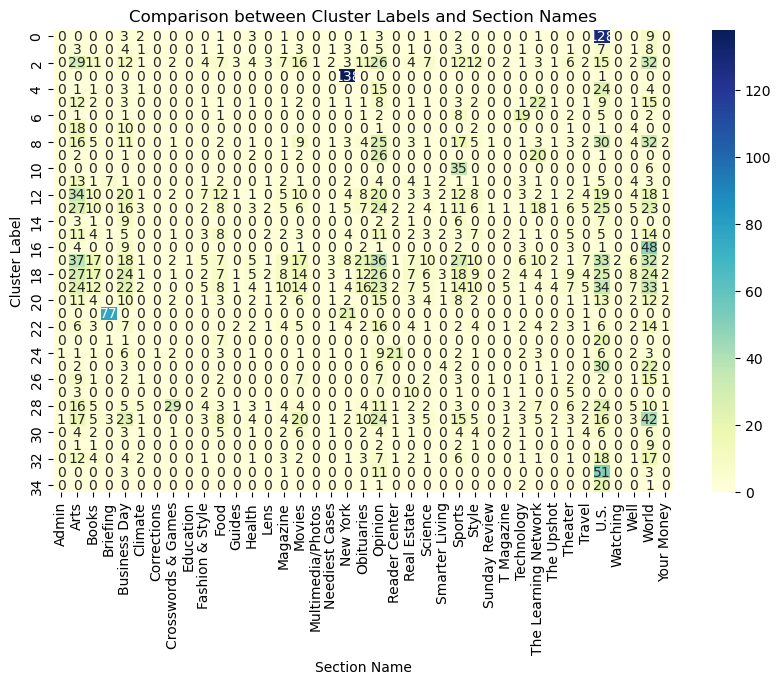

In [11]:
heatmap_data = dt.groupby(['cluster_label', 'section name']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Comparison between Cluster Labels and Section Names')
plt.xlabel('Section Name')
plt.ylabel('Cluster Label')
plt.show()

In [ ]:
data['Category'] = dt["section name"]
data['Keyword'] = df["lead paragraph keywords"]
df = pd.DataFrame(data)

category_keywords = {}

for index, row in df.iterrows():
    category = row['Category']
    keywords = row['Keyword'].split()  
    
    if category in category_keywords:
        category_keywords[category].extend(keywords)
    else:
        category_keywords[category] = keywords

fig, axes = plt.subplots(nrows=1, ncols=len(category_keywords), figsize=(100, 100))
for i, (category, keywords) in enumerate(category_keywords.items()):
    text = ' '.join(keywords)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Category {category}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [12]:
# optimal K

In [13]:
df['keywords'] = df['lead paragraph keywords'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

In [14]:
word2vec_model = Word2Vec(sentences=df['keywords'], vector_size=100, window=5, min_count=1, workers=4)

keyword_vectors = []
for row in df['keywords']:
    row_vectors = [word2vec_model.wv[keyword] for keyword in row if keyword in word2vec_model.wv]
    if row_vectors:
        row_mean_vector = np.mean(row_vectors, axis=0)
        keyword_vectors.append(row_mean_vector)

num_clusters = 13 
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(keyword_vectors)
clusters = kmeans.labels_

keyword_cluster_mapping = {}
for i, row in enumerate(df['keywords']):
    for j, keyword in enumerate(row):
        keyword_cluster_mapping[keyword] = clusters[i]

df['cluster_label'] = clusters        
new_silhouette_avg1 = silhouette_score(keyword_vectors, clusters)
print("Silhouette Score:", new_silhouette_avg1)

Silhouette Score: 0.09165863


In [15]:
dt['cluster_label'] = df['cluster_label']

In [ ]:
test =dt[['headline','cluster_label',"section name"]].groupby(['cluster_label',"section name"]).count()
test.sort_values(by='headline',ascending=False)

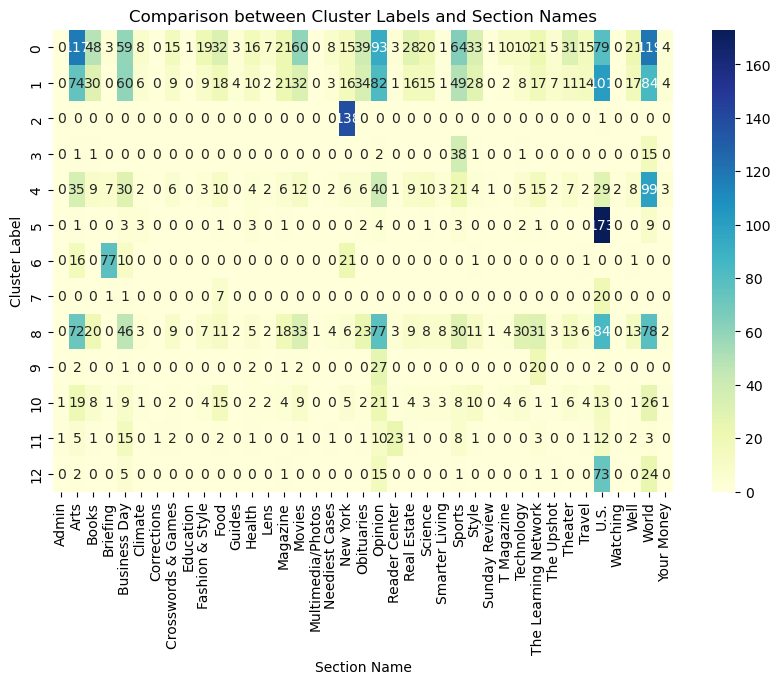

In [16]:
heatmap_data = dt.groupby(['cluster_label', 'section name']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Comparison between Cluster Labels and Section Names')
plt.xlabel('Section Name')
plt.ylabel('Cluster Label')
plt.show()

In [ ]:
data['Category'] = dt["section name"]
data['Keyword'] = df["lead paragraph keywords"]
df = pd.DataFrame(data)

category_keywords = {}

for index, row in df.iterrows():
    category = row['Category']
    keywords = row['Keyword'].split() 
    
    if category in category_keywords:
        category_keywords[category].extend(keywords)
    else:
        category_keywords[category] = keywords

fig, axes = plt.subplots(nrows=1, ncols=len(category_keywords), figsize=(100, 100))
for i, (category, keywords) in enumerate(category_keywords.items()):
    text = ' '.join(keywords)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Category {category}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Main Keywords lead paragraph (tf- idf) 

In [17]:
df['keywords'] = df['Main Keywords lead paragraph (tf- idf)'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

In [18]:
word2vec_model = Word2Vec(sentences=df['keywords'], vector_size=100, window=5, min_count=1, workers=4)

keyword_vectors = []
for row in df['keywords']:
    row_vectors = [word2vec_model.wv[keyword] for keyword in row if keyword in word2vec_model.wv]
    if row_vectors:
        row_mean_vector = np.mean(row_vectors, axis=0)
        keyword_vectors.append(row_mean_vector)

num_clusters = 35 
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(keyword_vectors)
clusters = kmeans.labels_

keyword_cluster_mapping = {}
for i, row in enumerate(df['keywords']):
    for j, keyword in enumerate(row):
        keyword_cluster_mapping[keyword] = clusters[i]


df['cluster_label'] = clusters        
silhouette_avg2 = silhouette_score(keyword_vectors, clusters)
print("Silhouette Score:", silhouette_avg2)

Silhouette Score: 0.34293428


In [ ]:
wcss = []
for i in range(1, 35):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=34, random_state=0)
    kmeans.fit(keyword_vectors)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(20, 20))
plt.plot(range(1, 35), wcss, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.xticks(range(1, 35))
plt.grid(True)
plt.show()

In [19]:
dt['cluster_label'] = df['cluster_label']

In [ ]:
test =dt[['headline','cluster_label',"section name"]].groupby(['cluster_label',"section name"]).count()
test.sort_values(by='headline',ascending=False)

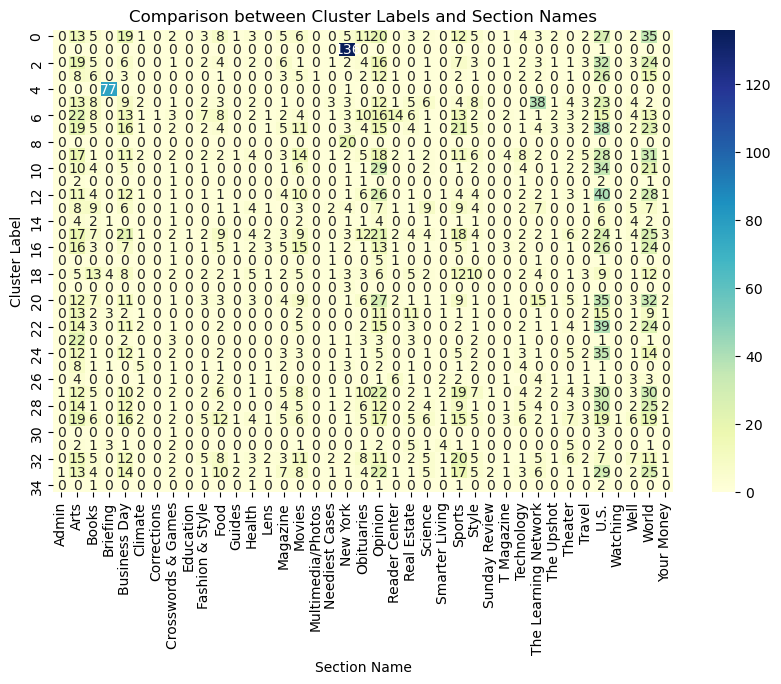

In [20]:
heatmap_data = dt.groupby(['cluster_label', 'section name']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Comparison between Cluster Labels and Section Names')
plt.xlabel('Section Name')
plt.ylabel('Cluster Label')
plt.show()

In [ ]:
data['Category'] = dt["section name"]
data['Keyword'] = df["Main Keywords abstract (tf- idf)"]
df = pd.DataFrame(data)

category_keywords = {}

for index, row in df.iterrows():
    category = row['Category']
    keywords = row['Keyword'].split()  
    
    if category in category_keywords:
        category_keywords[category].extend(keywords)
    else:
        category_keywords[category] = keywords

fig, axes = plt.subplots(nrows=1, ncols=len(category_keywords), figsize=(100, 100))
for i, (category, keywords) in enumerate(category_keywords.items()):
    text = ' '.join(keywords)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Category {category}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [21]:
#optimal K

In [22]:
df['keywords'] = df['Main Keywords lead paragraph (tf- idf)'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

In [23]:
word2vec_model = Word2Vec(sentences=df['keywords'], vector_size=100, window=5, min_count=1, workers=4)

keyword_vectors = []
for row in df['keywords']:
    row_vectors = [word2vec_model.wv[keyword] for keyword in row if keyword in word2vec_model.wv]
    if row_vectors:
        row_mean_vector = np.mean(row_vectors, axis=0)
        keyword_vectors.append(row_mean_vector)

num_clusters = 11 
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(keyword_vectors)
clusters = kmeans.labels_

keyword_cluster_mapping = {}
for i, row in enumerate(df['keywords']):
    for j, keyword in enumerate(row):
        keyword_cluster_mapping[keyword] = clusters[i]

df['cluster_label'] = clusters        
new_silhouette_avg2 = silhouette_score(keyword_vectors, clusters)
print("Silhouette Score:", new_silhouette_avg2)

Silhouette Score: 0.4670056


In [24]:
dt['cluster_label'] = df['cluster_label']

In [ ]:
test =dt[['headline','cluster_label',"section name"]].groupby(['cluster_label',"section name"]).count()
test.sort_values(by='headline',ascending=False)

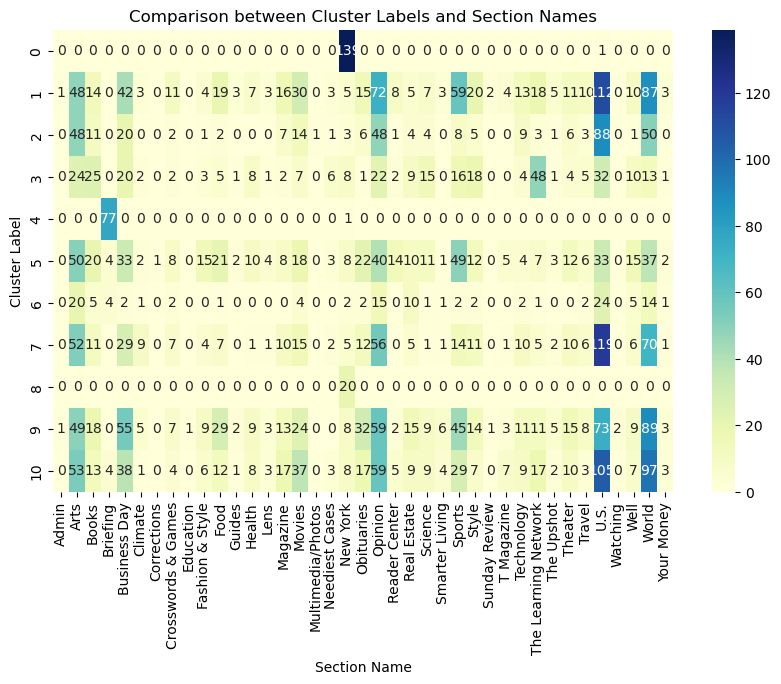

In [25]:
heatmap_data = dt.groupby(['cluster_label', 'section name']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Comparison between Cluster Labels and Section Names')
plt.xlabel('Section Name')
plt.ylabel('Cluster Label')
plt.show()

In [ ]:
data['Category'] = dt["section name"]
data['Keyword'] = df["Main Keywords abstract (tf- idf)"]
df = pd.DataFrame(data)

category_keywords = {}

for index, row in df.iterrows():
    category = row['Category']
    keywords = row['Keyword'].split() 
    
    if category in category_keywords:
        category_keywords[category].extend(keywords)
    else:
        category_keywords[category] = keywords

fig, axes = plt.subplots(nrows=1, ncols=len(category_keywords), figsize=(100, 100))
for i, (category, keywords) in enumerate(category_keywords.items()):
    text = ' '.join(keywords)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Category {category}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## abstract keywords

In [26]:
df['keywords'] = df['abstract keywords'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

In [27]:
word2vec_model = Word2Vec(sentences=df['keywords'], vector_size=100, window=5, min_count=1, workers=4)

keyword_vectors = []
for row in df['keywords']:
    row_vectors = [word2vec_model.wv[keyword] for keyword in row if keyword in word2vec_model.wv]
    if row_vectors:
        row_mean_vector = np.mean(row_vectors, axis=0)
        keyword_vectors.append(row_mean_vector)

num_clusters = 35 
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(keyword_vectors)
clusters = kmeans.labels_

keyword_cluster_mapping = {}
for i, row in enumerate(df['keywords']):
    for j, keyword in enumerate(row):
        keyword_cluster_mapping[keyword] = clusters[i]

df['cluster_label'] = clusters        
silhouette_avg3 = silhouette_score(keyword_vectors, clusters)
print("Silhouette Score:", silhouette_avg3)

Silhouette Score: 0.042862862


In [ ]:
wcss = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=29, random_state=0)
    kmeans.fit(keyword_vectors)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(20, 20))
plt.plot(range(1, 30), wcss, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.xticks(range(1, 30))
plt.grid(True)
plt.show()

In [28]:
#It can be seen that after the 10th time the distances between the K numbers remain relatively the same.
#A test was also done with a higher K number and there does not seem to be stabilization even after about 100 times, therefore we decided to stop the division into K after the stabilization of the distance.

In [29]:
dt['cluster_label'] = df['cluster_label']

In [ ]:
test =dt[['headline','cluster_label',"section name"]].groupby(['cluster_label',"section name"]).count()
test.sort_values(by='headline',ascending=False)

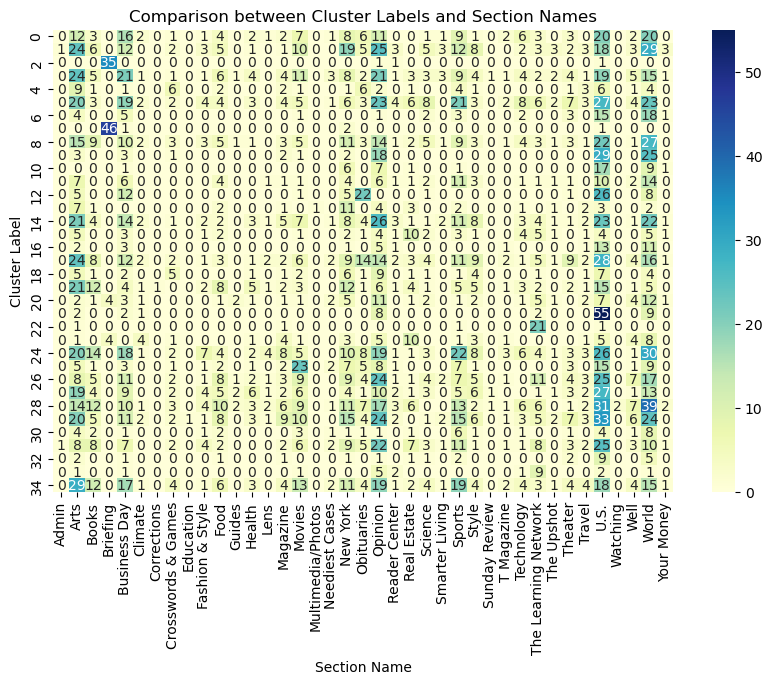

In [30]:
heatmap_data = dt.groupby(['cluster_label', 'section name']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Comparison between Cluster Labels and Section Names')
plt.xlabel('Section Name')
plt.ylabel('Cluster Label')
plt.show()

In [ ]:
data['Category'] = dt["section name"]
data['Keyword'] = df["abstract keywords"]
df = pd.DataFrame(data)

category_keywords = {}

for index, row in df.iterrows():
    category = row['Category']
    keywords = row['Keyword'].split()  

    if category in category_keywords:
        category_keywords[category].extend(keywords)
    else:
        category_keywords[category] = keywords

fig, axes = plt.subplots(nrows=1, ncols=len(category_keywords), figsize=(100, 100))
for i, (category, keywords) in enumerate(category_keywords.items()):
    text = ' '.join(keywords)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Category {category}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [31]:
# optimal k

In [32]:
df['keywords'] = df['abstract keywords'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

In [33]:
word2vec_model = Word2Vec(sentences=df['keywords'], vector_size=100, window=5, min_count=1, workers=4)

keyword_vectors = []
for row in df['keywords']:
    row_vectors = [word2vec_model.wv[keyword] for keyword in row if keyword in word2vec_model.wv]
    if row_vectors:
        row_mean_vector = np.mean(row_vectors, axis=0)
        keyword_vectors.append(row_mean_vector)

num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(keyword_vectors)
clusters = kmeans.labels_

keyword_cluster_mapping = {}
for i, row in enumerate(df['keywords']):
    for j, keyword in enumerate(row):
        keyword_cluster_mapping[keyword] = clusters[i]

df['cluster_label'] = clusters        
new_silhouette_avg3 = silhouette_score(keyword_vectors, clusters)
print("Silhouette Score:", new_silhouette_avg3)

Silhouette Score: 0.029137403


In [34]:
dt['cluster_label'] = df['cluster_label']

In [ ]:
test =dt[['headline','cluster_label',"section name"]].groupby(['cluster_label',"section name"]).count()
test.sort_values(by='headline',ascending=False)

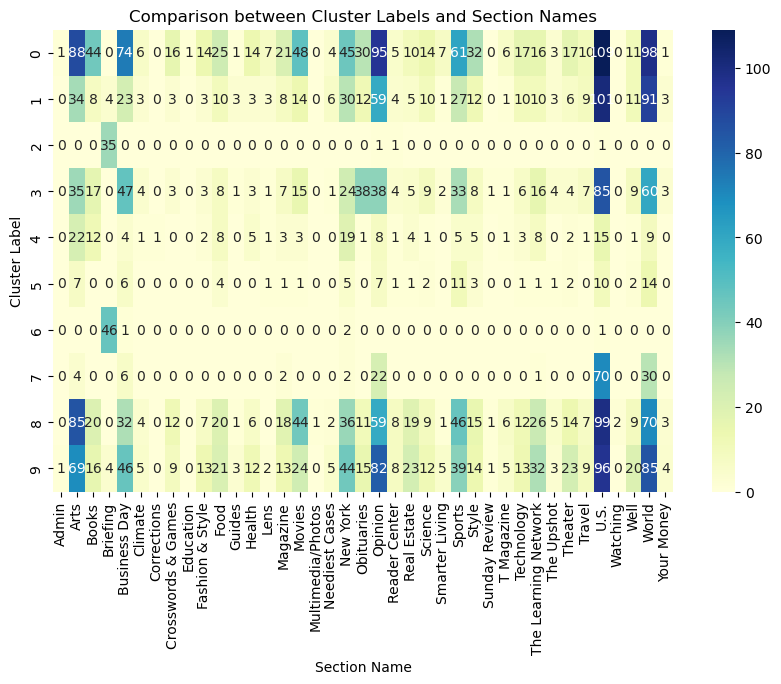

In [35]:
heatmap_data = dt.groupby(['cluster_label', 'section name']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Comparison between Cluster Labels and Section Names')
plt.xlabel('Section Name')
plt.ylabel('Cluster Label')
plt.show()

In [ ]:
data['Category'] = dt["section name"]
data['Keyword'] = df["abstract keywords"]
df = pd.DataFrame(data)

category_keywords = {}

for index, row in df.iterrows():
    category = row['Category']
    keywords = row['Keyword'].split()  
    
    if category in category_keywords:
        category_keywords[category].extend(keywords)
    else:
        category_keywords[category] = keywords

fig, axes = plt.subplots(nrows=1, ncols=len(category_keywords), figsize=(100, 100))
for i, (category, keywords) in enumerate(category_keywords.items()):
    text = ' '.join(keywords)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Category {category}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Main Keywords abstract (tf- idf)

In [36]:
df['keywords'] = df['Main Keywords abstract (tf- idf)'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

In [37]:
word2vec_model = Word2Vec(sentences=df['keywords'], vector_size=100, window=5, min_count=1, workers=4)

keyword_vectors = []
for row in df['keywords']:
    row_vectors = [word2vec_model.wv[keyword] for keyword in row if keyword in word2vec_model.wv]
    if row_vectors:
        row_mean_vector = np.mean(row_vectors, axis=0)
        keyword_vectors.append(row_mean_vector)

num_clusters = 35
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(keyword_vectors)
clusters = kmeans.labels_

keyword_cluster_mapping = {}
for i, row in enumerate(df['keywords']):
    for j, keyword in enumerate(row):
        keyword_cluster_mapping[keyword] = clusters[i]

df['cluster_label'] = clusters    
silhouette_avg4 = silhouette_score(keyword_vectors, clusters)
print("Silhouette Score:", silhouette_avg4)

Silhouette Score: 0.037666872


In [ ]:
wcss = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=29, random_state=0)
    kmeans.fit(keyword_vectors)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(20, 20))
plt.plot(range(1, 30), wcss, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.xticks(range(1, 30))
plt.grid(True)
plt.show()

In [38]:
# It can be seen that after the 11th time the distances between the K numbers remain relatively the same.

In [39]:
dt['cluster_label'] = df['cluster_label']

In [ ]:
test =dt[['headline','cluster_label',"section name"]].groupby(['cluster_label',"section name"]).count()
test.sort_values(by='headline',ascending=False)

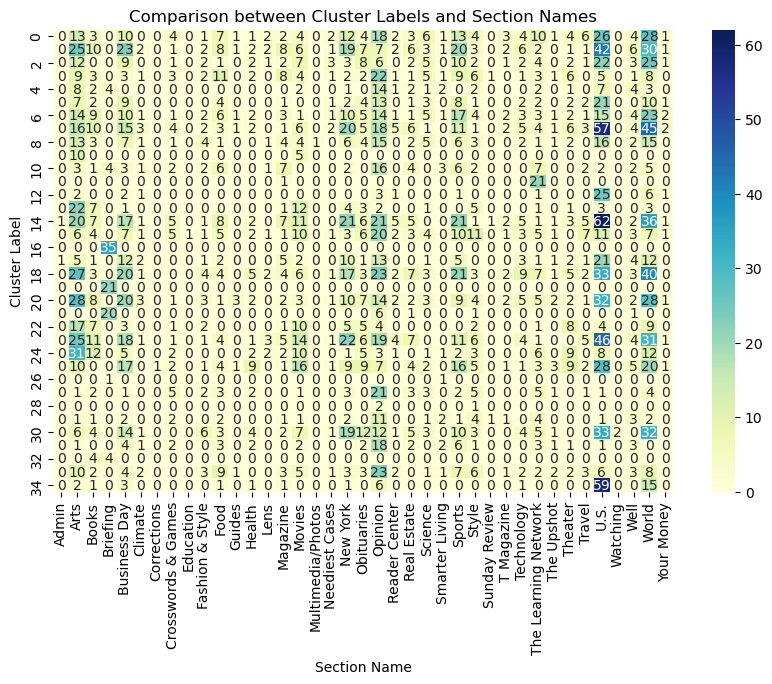

In [40]:
heatmap_data = dt.groupby(['cluster_label', 'section name']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Comparison between Cluster Labels and Section Names')
plt.xlabel('Section Name')
plt.ylabel('Cluster Label')
plt.show()

In [ ]:
data['Category'] = dt["section name"]
data['Keyword'] = df["Main Keywords abstract (tf- idf)"]
df = pd.DataFrame(data)

category_keywords = {}

for index, row in df.iterrows():
    category = row['Category']
    keywords = row['Keyword'].split()  
    
    if category in category_keywords:
        category_keywords[category].extend(keywords)
    else:
        category_keywords[category] = keywords

fig, axes = plt.subplots(nrows=1, ncols=len(category_keywords), figsize=(100, 100))
for i, (category, keywords) in enumerate(category_keywords.items()):
    text = ' '.join(keywords)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Category {category}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [41]:
#optimal k

In [42]:
df['keywords'] = df['Main Keywords abstract (tf- idf)'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

In [43]:
word2vec_model = Word2Vec(sentences=df['keywords'], vector_size=100, window=5, min_count=1, workers=4)

keyword_vectors = []
for row in df['keywords']:
    row_vectors = [word2vec_model.wv[keyword] for keyword in row if keyword in word2vec_model.wv]
    if row_vectors:
        row_mean_vector = np.mean(row_vectors, axis=0)
        keyword_vectors.append(row_mean_vector)

num_clusters = 11 
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(keyword_vectors)
clusters = kmeans.labels_

keyword_cluster_mapping = {}
for i, row in enumerate(df['keywords']):
    for j, keyword in enumerate(row):
        keyword_cluster_mapping[keyword] = clusters[i]

df['cluster_label'] = clusters    
new_silhouette_avg4 = silhouette_score(keyword_vectors, clusters)
print("Silhouette Score:", new_silhouette_avg4)

Silhouette Score: 0.04772036


In [44]:
dt['cluster_label'] = df['cluster_label']

In [ ]:
test =dt[['headline','cluster_label',"section name"]].groupby(['cluster_label',"section name"]).count()
test.sort_values(by='headline',ascending=False)

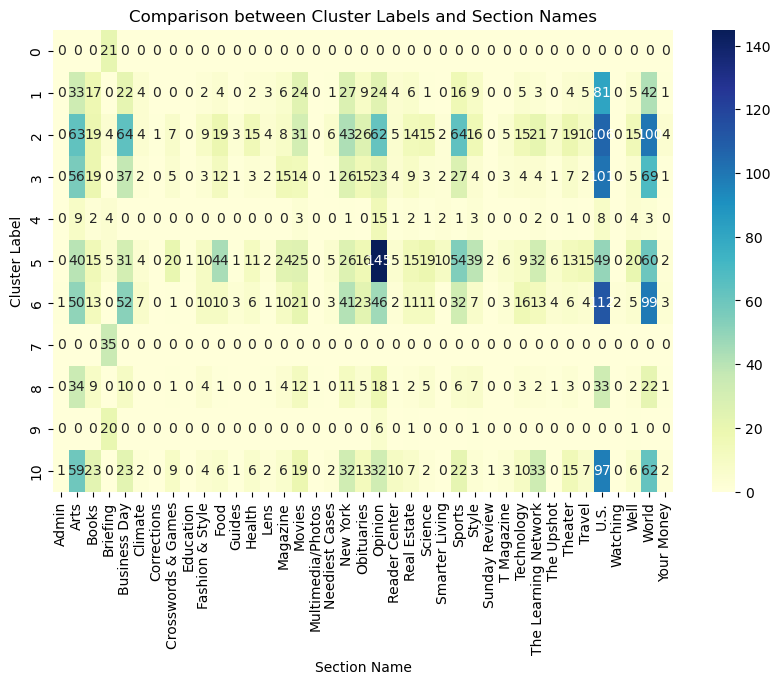

In [45]:
heatmap_data = dt.groupby(['cluster_label', 'section name']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Comparison between Cluster Labels and Section Names')
plt.xlabel('Section Name')
plt.ylabel('Cluster Label')
plt.show()

In [ ]:
data['Category'] = dt["section name"]
data['Keyword'] = df["Main Keywords abstract (tf- idf)"]
df = pd.DataFrame(data)

category_keywords = {}

for index, row in df.iterrows():
    category = row['Category']
    keywords = row['Keyword'].split() 
    
    if category in category_keywords:
        category_keywords[category].extend(keywords)
    else:
        category_keywords[category] = keywords

fig, axes = plt.subplots(nrows=1, ncols=len(category_keywords), figsize=(100, 100))
for i, (category, keywords) in enumerate(category_keywords.items()):
    text = ' '.join(keywords)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Category {category}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## headline keywords

In [46]:
df['keywords'] = df['headline keywords'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

In [47]:
word2vec_model = Word2Vec(sentences=df['keywords'], vector_size=100, window=5, min_count=1, workers=4)

keyword_vectors = []
for row in df['keywords']:
    row_vectors = [word2vec_model.wv[keyword] for keyword in row if keyword in word2vec_model.wv]
    if row_vectors:
        row_mean_vector = np.mean(row_vectors, axis=0)
        keyword_vectors.append(row_mean_vector)

num_clusters = 35 
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(keyword_vectors)
clusters = kmeans.labels_

keyword_cluster_mapping = {}
for i, row in enumerate(df['keywords']):
    for j, keyword in enumerate(row):
        keyword_cluster_mapping[keyword] = clusters[i]


df['cluster_label'] = clusters    
silhouette_avg5 = silhouette_score(keyword_vectors, clusters)
print("Silhouette Score:", silhouette_avg5)

Silhouette Score: 0.02870362


In [ ]:
wcss = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=29, random_state=0)
    kmeans.fit(keyword_vectors)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(20, 20))
plt.plot(range(1, 30), wcss, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.xticks(range(1, 30))
plt.grid(True)
plt.show()

In [48]:
#It can be seen that after the 18th time the distances between the K numbers remain relatively the same.
#A test was also done with a higher K number and there does not seem to be stabilization even after about 100 times, therefore we decided to stop the division into K after the stabilization of the distance.

In [49]:
dt['cluster_label'] = df['cluster_label']

In [ ]:
test =dt[['headline','cluster_label',"section name"]].groupby(['cluster_label',"section name"]).count()
test.sort_values(by='headline',ascending=False)

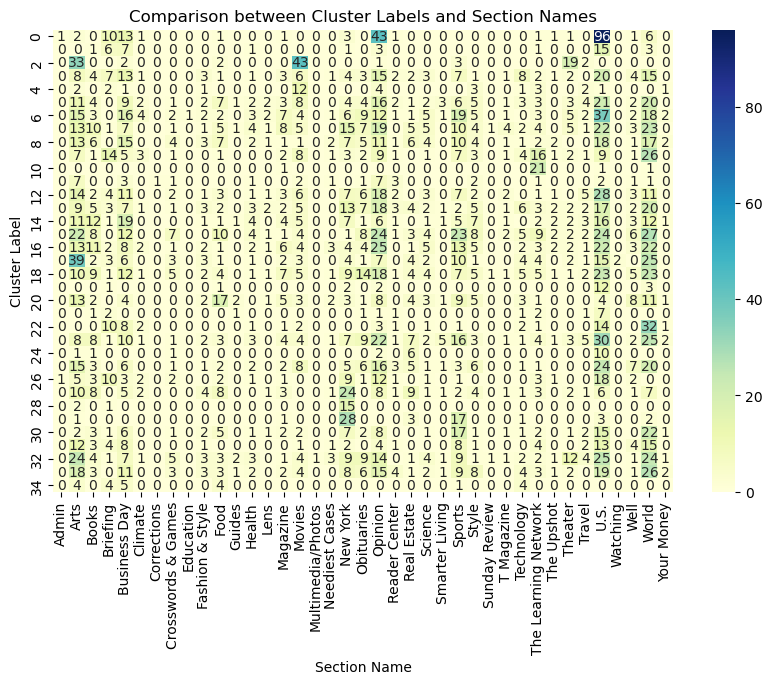

In [50]:
heatmap_data = dt.groupby(['cluster_label', 'section name']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Comparison between Cluster Labels and Section Names')
plt.xlabel('Section Name')
plt.ylabel('Cluster Label')
plt.show()

In [ ]:
data['Category'] = dt["section name"]
data['Keyword'] = df["Main Keywords abstract (tf- idf)"]
df = pd.DataFrame(data)

category_keywords = {}

for index, row in df.iterrows():
    category = row['Category']
    keywords = row['Keyword'].split() 
    
    if category in category_keywords:
        category_keywords[category].extend(keywords)
    else:
        category_keywords[category] = keywords

fig, axes = plt.subplots(nrows=1, ncols=len(category_keywords), figsize=(100, 100))
for i, (category, keywords) in enumerate(category_keywords.items()):
    text = ' '.join(keywords)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Category {category}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [51]:
#optimal k

In [52]:
df['keywords'] = df['headline keywords'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

In [53]:
word2vec_model = Word2Vec(sentences=df['keywords'], vector_size=100, window=5, min_count=1, workers=4)

keyword_vectors = []
for row in df['keywords']:
    row_vectors = [word2vec_model.wv[keyword] for keyword in row if keyword in word2vec_model.wv]
    if row_vectors:
        row_mean_vector = np.mean(row_vectors, axis=0)
        keyword_vectors.append(row_mean_vector)

num_clusters = 18
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(keyword_vectors)
clusters = kmeans.labels_

keyword_cluster_mapping = {}
for i, row in enumerate(df['keywords']):
    for j, keyword in enumerate(row):
        keyword_cluster_mapping[keyword] = clusters[i]

df['cluster_label'] = clusters    
new_silhouette_avg5 = silhouette_score(keyword_vectors, clusters)
print("Silhouette Score:", new_silhouette_avg5)

Silhouette Score: 0.023593606


In [54]:
dt['cluster_label'] = df['cluster_label']

In [ ]:
test =dt[['headline','cluster_label',"section name"]].groupby(['cluster_label',"section name"]).count()
test.sort_values(by='headline',ascending=False)

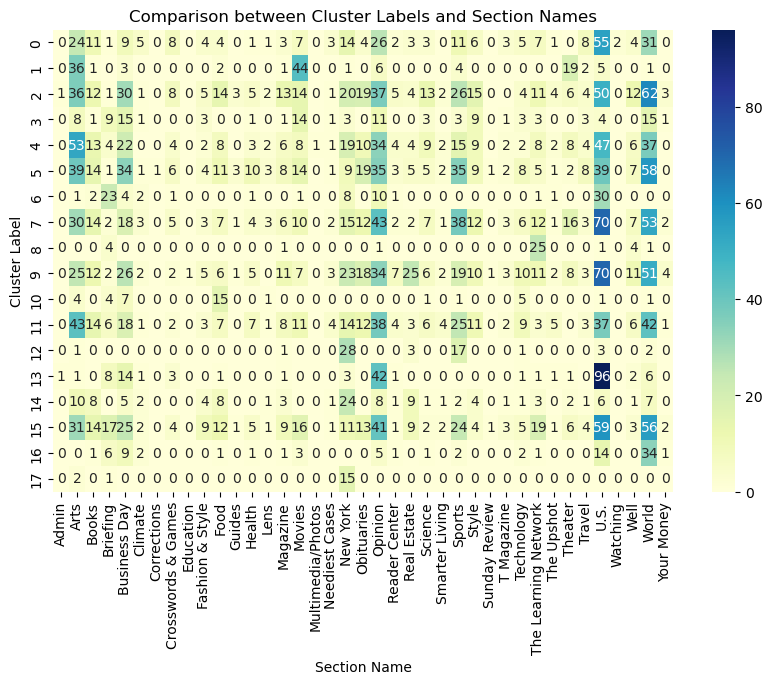

In [55]:
heatmap_data = dt.groupby(['cluster_label', 'section name']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Comparison between Cluster Labels and Section Names')
plt.xlabel('Section Name')
plt.ylabel('Cluster Label')
plt.show()

In [ ]:
data['Category'] = dt["section name"]
data['Keyword'] = df["Main Keywords abstract (tf- idf)"]
df = pd.DataFrame(data)

category_keywords = {}

for index, row in df.iterrows():
    category = row['Category']
    keywords = row['Keyword'].split()  
    
    if category in category_keywords:
        category_keywords[category].extend(keywords)
    else:
        category_keywords[category] = keywords

fig, axes = plt.subplots(nrows=1, ncols=len(category_keywords), figsize=(100, 100))
for i, (category, keywords) in enumerate(category_keywords.items()):
    text = ' '.join(keywords)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Category {category}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Main Keywords headline (tf- idf)

In [56]:
df['keywords'] = df['Main Keywords headline (tf- idf)'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

In [57]:
word2vec_model = Word2Vec(sentences=df['keywords'], vector_size=100, window=5, min_count=1, workers=4)

keyword_vectors = []
for row in df['keywords']:
    row_vectors = [word2vec_model.wv[keyword] for keyword in row if keyword in word2vec_model.wv]
    if row_vectors:
        row_mean_vector = np.mean(row_vectors, axis=0)
        keyword_vectors.append(row_mean_vector)

num_clusters = 35
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(keyword_vectors)
clusters = kmeans.labels_

keyword_cluster_mapping = {}
for i, row in enumerate(df['keywords']):
    for j, keyword in enumerate(row):
        keyword_cluster_mapping[keyword] = clusters[i]

df['cluster_label'] = clusters    
silhouette_avg6 = silhouette_score(keyword_vectors, clusters)
print("Silhouette Score:", silhouette_avg6)

Silhouette Score: -0.00068679656


In [ ]:
wcss = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=29, random_state=0)
    kmeans.fit(keyword_vectors)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(20, 20))
plt.plot(range(1, 30), wcss, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.xticks(range(1, 30))
plt.grid(True)
plt.show()

In [58]:
# It can be seen that after the 12th time the distances between the K numbers remain relatively the same.

In [59]:
dt['cluster_label'] = df['cluster_label']

In [ ]:
test =dt[['headline','cluster_label',"section name"]].groupby(['cluster_label',"section name"]).count()
test.sort_values(by='headline',ascending=False)

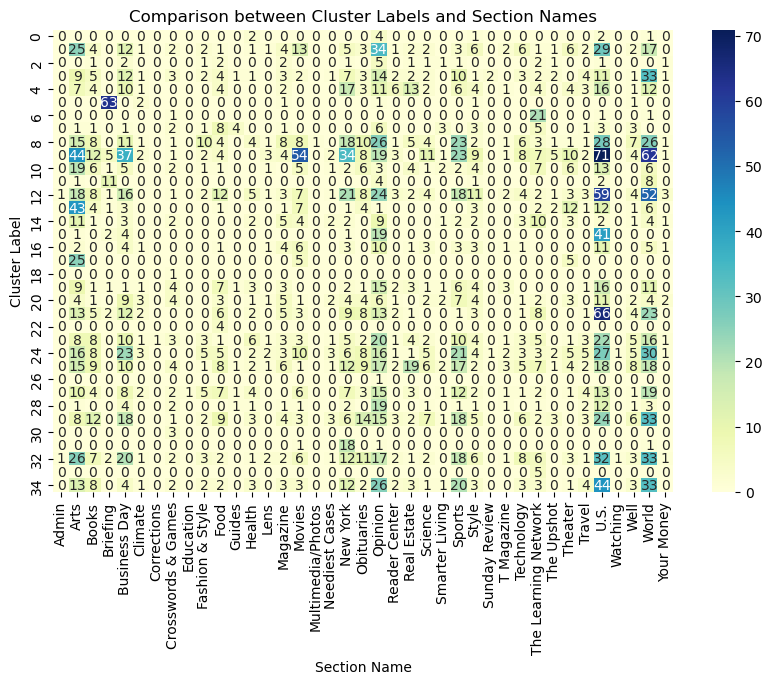

In [60]:
heatmap_data = dt.groupby(['cluster_label', 'section name']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Comparison between Cluster Labels and Section Names')
plt.xlabel('Section Name')
plt.ylabel('Cluster Label')
plt.show()

In [ ]:
data['Category'] = dt["section name"]
data['Keyword'] = df["Main Keywords abstract (tf- idf)"]
df = pd.DataFrame(data)

category_keywords = {}

for index, row in df.iterrows():
    category = row['Category']
    keywords = row['Keyword'].split() 

    if category in category_keywords:
        category_keywords[category].extend(keywords)
    else:
        category_keywords[category] = keywords

fig, axes = plt.subplots(nrows=1, ncols=len(category_keywords), figsize=(100, 100))
for i, (category, keywords) in enumerate(category_keywords.items()):
    text = ' '.join(keywords)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Category {category}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [61]:
#optimal k

In [62]:
df['keywords'] = df['Main Keywords headline (tf- idf)'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

In [63]:
word2vec_model = Word2Vec(sentences=df['keywords'], vector_size=100, window=5, min_count=1, workers=4)

keyword_vectors = []
for row in df['keywords']:
    row_vectors = [word2vec_model.wv[keyword] for keyword in row if keyword in word2vec_model.wv]
    if row_vectors:
        row_mean_vector = np.mean(row_vectors, axis=0)
        keyword_vectors.append(row_mean_vector)

num_clusters = 12 
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(keyword_vectors)
clusters = kmeans.labels_

keyword_cluster_mapping = {}
for i, row in enumerate(df['keywords']):
    for j, keyword in enumerate(row):
        keyword_cluster_mapping[keyword] = clusters[i]

df['cluster_label'] = clusters    
new_silhouette_avg6 = silhouette_score(keyword_vectors, clusters)
print("Silhouette Score:", new_silhouette_avg6)

Silhouette Score: -0.011705052


In [64]:
dt['cluster_label'] = df['cluster_label']

In [ ]:
test =dt[['headline','cluster_label',"section name"]].groupby(['cluster_label',"section name"]).count()
test.sort_values(by='headline',ascending=False)

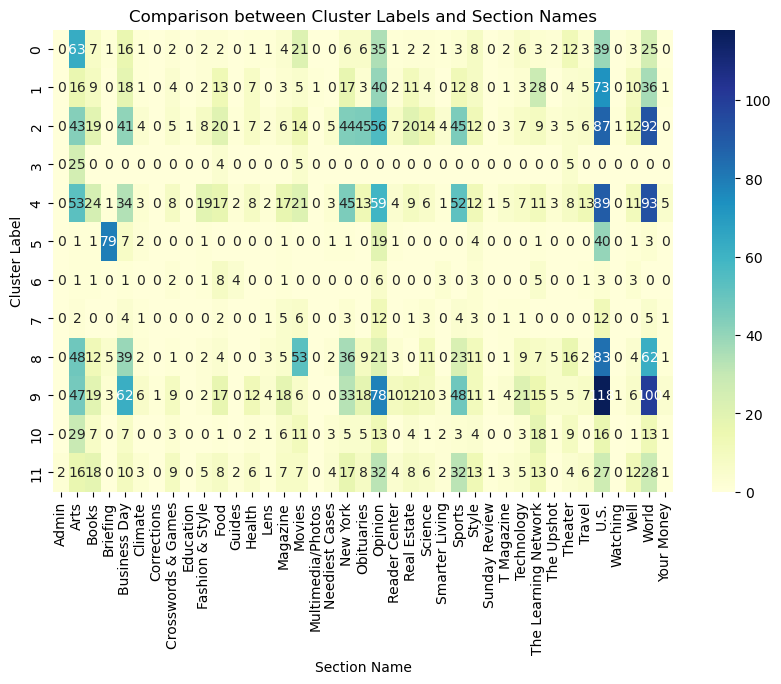

In [65]:
heatmap_data = dt.groupby(['cluster_label', 'section name']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Comparison between Cluster Labels and Section Names')
plt.xlabel('Section Name')
plt.ylabel('Cluster Label')
plt.show()

In [ ]:
data['Category'] = dt["section name"]
data['Keyword'] = df["Main Keywords abstract (tf- idf)"]
df = pd.DataFrame(data)

category_keywords = {}

for index, row in df.iterrows():
    category = row['Category']
    keywords = row['Keyword'].split() 
    
    if category in category_keywords:
        category_keywords[category].extend(keywords)
    else:
        category_keywords[category] = keywords

fig, axes = plt.subplots(nrows=1, ncols=len(category_keywords), figsize=(100, 100))
for i, (category, keywords) in enumerate(category_keywords.items()):
    text = ' '.join(keywords)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Category {category}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## first keyword

In [66]:
data = df['first keyword']
data = data.dropna()

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data)

k = 35  
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
labels = kmeans.labels_


silhouette_avg7 = silhouette_score(X, labels)
print("Silhouette Score:", silhouette_avg7)

Silhouette Score: 0.35328908375633644


In [ ]:
wcss = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=29, random_state=0)
    kmeans.fit(keyword_vectors)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(20, 20))
plt.plot(range(1, 30), wcss, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.xticks(range(1, 30))
plt.grid(True)
plt.show()

In [67]:
# It can be seen that after the 16th time the distances between the K numbers remain relatively the same.

In [68]:
#optimal k

In [69]:
data = df['first keyword']
data = data.dropna()

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data)

k = 16  
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
labels = kmeans.labels_

new_silhouette_avg7 = silhouette_score(X, labels)
print("Silhouette Score:", new_silhouette_avg7)

Silhouette Score: 0.25012343092330125


## Silhouette Score table (k=35)

In [70]:
Silhouette_Score_table = pd.DataFrame({
    'lead paragraph keywords': [silhouette_avg1],
    'Main Keywords lead paragraph (tf- idf)': [silhouette_avg2],
    'abstract keywords': [silhouette_avg3],
    'Main Keywords abstract (tf- idf)': [silhouette_avg4],
    'headline keywords': [silhouette_avg5],
    'Main Keywords headline (tf- idf)': [silhouette_avg6],
    'first keyword': [silhouette_avg7],
})
Silhouette_Score_table

,lead paragraph keywords,Main Keywords lead paragraph (tf- idf),abstract keywords,Main Keywords abstract (tf- idf),headline keywords,Main Keywords headline (tf- idf),first keyword
0,0.103666,0.342934,0.042863,0.037667,0.028704,-0.000687,0.353289


## Silhouette Score table (k=optimal)

In [71]:
Silhouette_Score_table_optimal = pd.DataFrame({
    'lead paragraph keywords': [new_silhouette_avg1],
    'Main Keywords lead paragraph (tf- idf)': [new_silhouette_avg2],
    'abstract keywords': [new_silhouette_avg3],
    'Main Keywords abstract (tf- idf)': [new_silhouette_avg4],
    'headline keywords': [new_silhouette_avg5],
    'Main Keywords headline (tf- idf)': [new_silhouette_avg6],
    'first keyword': [new_silhouette_avg7],
})
Silhouette_Score_table_optimal

,lead paragraph keywords,Main Keywords lead paragraph (tf- idf),abstract keywords,Main Keywords abstract (tf- idf),headline keywords,Main Keywords headline (tf- idf),first keyword
0,0.091659,0.467006,0.029137,0.04772,0.023594,-0.011705,0.250123


In [72]:
#the only improvement is in TF_IDF columns. 

In [74]:
#Main Keywords lead paragraph (tf- idf) Silhouette Score is the highiest but it is still low whice Indicates that some values may fall under a different category